In [1]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.utils.validation import check_symmetric
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans, SpectralClustering, spectral_clustering, k_means
from sklearn.manifold import spectral_embedding

from graspologic.plot import adjplot
from graspologic.embed import AdjacencySpectralEmbed, LaplacianSpectralEmbed   
from graspologic.utils import remap_labels, is_symmetric
from graspologic.simulations import sbm

from tqdm import tqdm
import warnings

/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#2+ hours to run one simulation of 30000 vertices
n_sims = 30
n_verts = [100, 500, 1000, 5000, 10000, 20000, 30000]

B_aff = np.array([[0.050, 0.013], [0.013, 0.051]])
B_core = np.array([[0.011, 0.027], [0.027, 0.079]])

warnings.filterwarnings("ignore")

In [3]:
#example of going from block matrix to probability matrix to latent position matrix to k neighbors graph

#given affinity block matrix
B_aff = np.array([[0.050, 0.013], [0.013, 0.051]])

#will iterate through list of n_verts in simulation, but use n_verts=6 as example (3 verts per block)
n = 6

#make probability matrix
P = np.zeros((n, n))
P[0:int(n/2),0:int(n/2)] = B_aff[0, 0]
P[int(n/2):n, int(n/2):n] = B_aff[1, 1]
P[0:int(n/2), int(n/2):n] = B_aff[0, 1]
P[int(n/2):n, 0:int(n/2)] = B_aff[1, 0]

#make latent position matrix
U, S, V = np.linalg.svd(P)

#sample half the points from U
X = U[0:int(n/2), 0:2] @ np.sqrt(np.diag(S[0:2]))

#sample half the points from V^T
Y = V.T[int(n/2):n, 0:2] @ np.sqrt(np.diag(S[0:2]))

#concatenate the two matrices to get the full latent position matrix
lat_mat = np.concatenate((X, Y), axis=0)

#get k_neighbors graph from latent position matrix
kn_graph = kneighbors_graph(lat_mat, n_neighbors=4)
print(kn_graph.toarray())
print(is_symmetric(kn_graph))


[[0. 1. 1. 1. 1. 0.]
 [1. 0. 1. 1. 1. 0.]
 [1. 1. 0. 1. 1. 0.]
 [1. 1. 0. 0. 1. 1.]
 [1. 1. 0. 1. 0. 1.]
 [1. 1. 0. 1. 1. 0.]]
False


In [4]:
def calc_ari(B, embed_method):
    rows = []
    
    #progress bar for the outer loop over n_verts
    for n in tqdm(n_verts, desc="Vertices"):
        # Generate the true labels
        labels_sbm = int(n/2) * [0] + int(n/2) * [1]

        #make probability matrix from block matrix
        P = np.zeros((n, n))
        P[0:int(n/2),0:int(n/2)] = B_aff[0, 0]
        P[int(n/2):n, int(n/2):n] = B_aff[1, 1]
        P[0:int(n/2), int(n/2):n] = B_aff[0, 1]
        P[int(n/2):n, 0:int(n/2)] = B_aff[1, 0]

        #make latent position matrix
        U, S, V = np.linalg.svd(P)

        #sample half the points from U
        X = U[0:int(n/2), 0:2] @ np.sqrt(np.diag(S[0:2]))

        #sample half the points from V^T
        Y = V.T[int(n/2):n, 0:2] @ np.sqrt(np.diag(S[0:2]))

        #concatenate the two matrices to get the full latent position matrix
        lat_mat = np.concatenate((X, Y), axis=0)

        #get k_neighbors graph from latent position matrix (k=sqrt(n))
        kn_graph = kneighbors_graph(lat_mat, n_neighbors=int(np.sqrt(n)))
        kn_graph = kn_graph.toarray()

        #progress bar for the inner loop over simulations
        for _ in tqdm(range(n_sims), desc="Simulations", position=1, leave=True):
            #choose embedding method
            if embed_method == "ase":
                ase = AdjacencySpectralEmbed(n_components=2)
                Xhat, Yhat = ase.fit_transform(kn_graph)
            elif embed_method == "lse":
                lse = LaplacianSpectralEmbed(n_components=2)
                Xhat, Yhat = lse.fit_transform(kn_graph)
            elif embed_method == "sklearn":
                Xhat = spectral_embedding(kn_graph, n_components=2)


            #concatenate Xhat and Yhat if using ase or lse
            if embed_method == "ase" or embed_method == "lse":
                Xhat = np.concatenate((Xhat, Yhat), axis=1)

            #calculate the ARI score
            labels_kmeans = KMeans(n_clusters=2).fit_predict(Xhat)
            ari = adjusted_rand_score(labels_sbm, labels_kmeans)
            result = {
                "test": embed_method,
                "n_vert": n,
                "ari": ari
            }
            rows.append(result)
        print(n)

    results = pd.DataFrame(rows)
    return results

In [5]:
#comparison of embedding methods on affinity graph (LSE should do best)
ari_aff_lse_df = calc_ari(B = B_aff, embed_method = "lse")
ari_aff_ase_df = calc_ari(B = B_aff, embed_method = "ase")
ari_aff_sklearn_df = calc_ari(B = B_aff, embed_method = "sklearn")
ari_aff_df = pd.concat([ari_aff_lse_df, ari_aff_sklearn_df])
ari_aff_df = pd.concat([ari_aff_lse_df, ari_aff_ase_df, ari_aff_sklearn_df])
#ari_aff_df.to_csv("ari_aff_df.csv")

Vertices:  14%|█▍        | 1/7 [00:00<00:02,  2.60it/s]

100


Vertices:  29%|██▊       | 2/7 [00:01<00:03,  1.33it/s]

500


Vertices:  43%|████▎     | 3/7 [00:08<00:14,  3.75s/it]

1000


Vertices:  57%|█████▋    | 4/7 [05:16<06:10, 123.61s/it]

5000


Vertices:  71%|███████▏  | 5/7 [31:04<21:15, 637.51s/it]

10000


Vertices:  86%|████████▌ | 6/7 [4:26:05<1:26:55, 5215.15s/it]

20000


Vertices: 100%|██████████| 7/7 [16:10:10<00:00, 8315.73s/it] 


30000


Vertices:  14%|█▍        | 1/7 [00:00<00:02,  2.47it/s]

100


Vertices:  29%|██▊       | 2/7 [00:01<00:03,  1.33it/s]

500


Vertices:  43%|████▎     | 3/7 [00:04<00:06,  1.60s/it]

1000


Vertices:  57%|█████▋    | 4/7 [01:53<02:12, 44.14s/it]

5000


Vertices:  71%|███████▏  | 5/7 [11:21<07:45, 232.98s/it]

10000


Vertices:  86%|████████▌ | 6/7 [1:13:31<23:42, 1422.06s/it]

20000


Vertices: 100%|██████████| 7/7 [5:47:49<00:00, 2981.39s/it]


30000


Vertices:  14%|█▍        | 1/7 [00:00<00:02,  2.19it/s]

100


Vertices:  29%|██▊       | 2/7 [00:01<00:04,  1.06it/s]

500


Vertices:  43%|████▎     | 3/7 [00:04<00:06,  1.73s/it]

1000


Vertices:  57%|█████▋    | 4/7 [02:12<02:35, 51.78s/it]

5000


Vertices:  71%|███████▏  | 5/7 [14:26<09:55, 297.67s/it]

10000


Vertices:  86%|████████▌ | 6/7 [1:53:11<36:51, 2211.00s/it]

20000


Vertices: 100%|██████████| 7/7 [7:33:23<00:00, 3886.28s/it]


30000


In [6]:
#get the means across the sims (groupby test and n_vert)
ari_aff_means = ari_aff_df.groupby(["test", "n_vert"]).mean()
ari_aff_means

ari
test    n_vert          
ase     100     0.582482
        500     0.691045
        1000    0.749228
        5000    0.796318
        10000   0.832733
        20000   0.632899
        30000   0.833133
lse     100     0.617848
        500     0.001742
        1000    0.004005
        5000    0.662612
        10000   0.000263
        20000   0.566720
        30000   0.266769
sklearn 100     0.271413
        500     0.276873
        1000    0.216550
        5000    0.321494
        10000   0.313234
        20000   0.293474
        30000   0.433382

Text(0.5, 1.0, 'ARI of Affinity Graph using Different Embedding Methods')

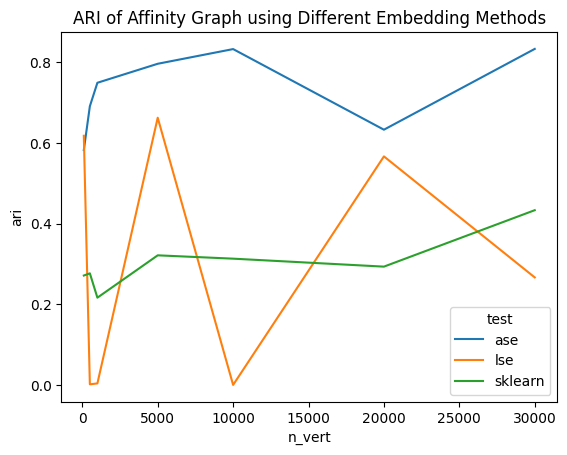

In [7]:
#make lse vs sklearn affinity plot
sns.lineplot(data=ari_aff_means, x="n_vert", y="ari", hue="test", errorbar=None)
plt.title('ARI of Affinity Graph using Different Embedding Methods')

In [8]:
#comparison of embedding methods on core periphery graph (ASE should do best)
ari_core_ase_df = calc_ari(B = B_core, embed_method = "ase")
ari_core_lse_df = calc_ari(B = B_core, embed_method = "lse")
ari_core_sklearn_df = calc_ari(B = B_core, embed_method = "sklearn")
ari_core_df = pd.concat([ari_core_ase_df, ari_core_sklearn_df])
ari_core_df = pd.concat([ari_core_ase_df, ari_core_lse_df, ari_core_sklearn_df])
ari_core_df.to_csv("ari_core_df.csv")

Vertices:  14%|█▍        | 1/7 [00:00<00:03,  1.83it/s]

100


Vertices:  29%|██▊       | 2/7 [00:01<00:03,  1.66it/s]

500


Vertices:  43%|████▎     | 3/7 [00:03<00:05,  1.49s/it]

1000


Vertices:  57%|█████▋    | 4/7 [01:52<02:11, 43.91s/it]

5000


Vertices:  71%|███████▏  | 5/7 [11:00<07:31, 225.56s/it]

10000


Vertices:  86%|████████▌ | 6/7 [1:11:02<22:53, 1373.50s/it]

20000


Vertices: 100%|██████████| 7/7 [4:58:21<00:00, 2557.30s/it]


30000


Vertices:  14%|█▍        | 1/7 [00:00<00:02,  2.98it/s]

100


Vertices:  29%|██▊       | 2/7 [00:01<00:03,  1.64it/s]

500


Vertices:  43%|████▎     | 3/7 [00:05<00:09,  2.37s/it]

1000


Vertices:  57%|█████▋    | 4/7 [03:24<03:59, 79.80s/it]

5000


Vertices:  71%|███████▏  | 5/7 [24:25<16:51, 505.91s/it]

10000


Vertices:  86%|████████▌ | 6/7 [3:15:26<1:03:42, 3822.74s/it]

20000


Vertices: 100%|██████████| 7/7 [13:29:42<00:00, 6940.43s/it] 


30000


Vertices:  14%|█▍        | 1/7 [00:00<00:02,  2.65it/s]

100


Vertices:  29%|██▊       | 2/7 [00:01<00:03,  1.43it/s]

500


Vertices:  43%|████▎     | 3/7 [00:03<00:06,  1.56s/it]

1000


Vertices:  57%|█████▋    | 4/7 [01:54<02:14, 44.78s/it]

5000


Vertices:  71%|███████▏  | 5/7 [12:24<08:31, 255.68s/it]

10000


Vertices:  86%|████████▌ | 6/7 [1:29:47<29:07, 1747.41s/it]

20000


Vertices: 100%|██████████| 7/7 [6:17:32<00:00, 3236.06s/it]


30000


In [9]:
#get the means across the sims (groupby test and n_vert)
ari_core_means = ari_core_df.groupby(["test", "n_vert"]).mean()
ari_core_means

ari
test    n_vert          
ase     100     0.550365
        500     0.625937
        1000    0.684401
        5000    0.829466
        10000   0.799439
        20000   0.699499
        30000   0.766493
lse     100     0.617848
        500     0.003131
        1000    0.004953
        5000    0.563332
        10000   0.033593
        20000   0.600053
        30000   0.466720
sklearn 100     0.365715
        500     0.113951
        1000    0.325099
        5000    0.295412
        10000   0.310152
        20000   0.262000
        30000   0.400062

Text(0.5, 1.0, 'ARI of Core Periphery Graph using Different Embedding Methods')

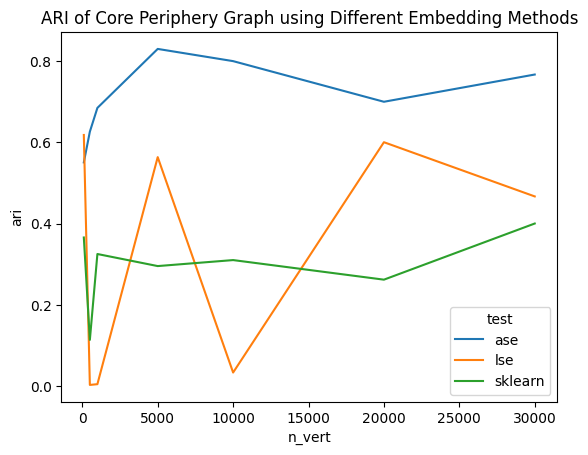

In [10]:
#make ase vs sklearn core periphery plot
sns.lineplot(data=ari_core_means, x="n_vert", y="ari", hue="test", errorbar=None)
plt.title('ARI of Core Periphery Graph using Different Embedding Methods')